# Wine Rating Prediction
In this notebook, I explored wine review dataset and attempted to predict wine points based on various features. First, I extracted years by using regex on 'title' column. I started by doing some basic exploratory data analysis (EDA) and data cleaning. Then, I preprocessed the data by using tf-idf on the descriptions column and one-hot-encoding the variety column. In addition, I used pycountry library to get relevant continents according to countries.

Next, I split the data into training and test sets, and trained three models on the training data: SVM, Ridge Regression, and Neural Networks. I then evaluated the performance of each model on the test data and found that SVM showed higher results but Ridge was much faster.

Overall, this notebook provides an overview of the wine quality dataset, demonstrates some common preprocessing techniques for text and categorical data, and compares the performance of popular regression algorithms.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import category_encoders as ce
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import pycountry
import pycountry_convert as pc

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('../winemag-data-130k-v2.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [5]:
df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [6]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
# extract the year from the title column
df['year'] = df['title'].str.extract('([1-2][0-9]{3})').astype('float64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
 13  year                   125362 non-null  float64
dtypes: float64(2), int64(1), object(11)


In [9]:
# convert countries to continents using pycountry_convert
def country_to_continent(country_name):
    try:
        country_alpha2 = pycountry.countries.get(name=country_name).alpha_2
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except:
        return np.nan

df['continent'] = df['country'].apply(country_to_continent)

In [10]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,continent
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0,EU
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0,EU
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0,NaN
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0,NaN
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0,NaN


In [11]:
# assign continent to US 
df.loc[df['country'] == 'US', 'continent'] = 'NA'

In [12]:
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
year                      4609
continent                  220
dtype: int64

In [13]:
# countries that are missing continent
df['country'][df['continent'].isnull()].unique()

array([nan, 'Czech Republic', 'England', 'Moldova', 'Macedonia'],
      dtype=object)

In [14]:
# assign continent to missing countries
df.loc[df['country'] == 'England', 'continent'] = 'EU'
df.loc[df['country'] == 'Moldova', 'continent'] = 'EU'
df.loc[df['country'] == 'Czech Republic', 'continent'] = 'EU'
df.loc[df['country'] == 'Macedonia', 'continent'] = 'EU'

In [15]:
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
year                      4609
continent                   63
dtype: int64

Now the number of missing countries has dropped.

According to the number of unique values, I decided to drop the following columns: region_1, region_2, taster_name, taster_twitter_handle, title, and winery.

In [16]:
# determining the df we will use for machine learning
df2 = df[['country', 'description', 'points', 'price', 'variety', 'year', 'continent']]
df2.head()

,country,description,points,price,variety,year,continent
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,2013.0,EU
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,2011.0,EU
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,2013.0,NA
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,2013.0,NA
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,2012.0,NA


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   year         125362 non-null  float64
 6   continent    129908 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 7.9+ MB


In [18]:
df2.isnull().sum()

country          63
description       0
points            0
price          8996
variety           1
year           4609
continent        63
dtype: int64

The number of null values is not that high, so I will drop them:

In [19]:
# drop rows with missing values
df2 = df2.dropna(axis=0)

# # drop rows with duplicate values
df2 = df2.drop_duplicates(keep='first')

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107712 entries, 1 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      107712 non-null  object 
 1   description  107712 non-null  object 
 2   points       107712 non-null  int64  
 3   price        107712 non-null  float64
 4   variety      107712 non-null  object 
 5   year         107712 non-null  float64
 6   continent    107712 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 6.6+ MB


Here I'm grouping rows that have all columns identical to description, and I'm joining the descriptions. This way we will have less rows.

In [20]:
# group the DataFrame by all columns except the description column
grouped = df2.groupby(['country', 'points', 'price', 'variety', 'year', 'continent'])

# create a new DataFrame to store the combined descriptions
df_combined_desc = pd.DataFrame(columns=['country', 'points', 'price', 'variety', 'year', 'continent', 'description'])

# loop through each group
for name, group in grouped:
    # get the description values as a list
    descriptions = group['description'].tolist()
    # join the descriptions using a separator
    combined_desc = '; '.join(descriptions)
    # create a new row with the combined descriptions
    new_row = {'country': name[0], 'points': name[1], 'price': name[2], 'variety': name[3], 'year': name[4], 'continent': name[5], 'description': combined_desc}
    # append the new row to the DataFrame
    df_combined_desc = df_combined_desc.append(new_row, ignore_index=True)

In [21]:
df_combined_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79752 entries, 0 to 79751
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      79752 non-null  object 
 1   points       79752 non-null  object 
 2   price        79752 non-null  float64
 3   variety      79752 non-null  object 
 4   year         79752 non-null  float64
 5   continent    79752 non-null  object 
 6   description  79752 non-null  object 
dtypes: float64(2), object(5)
memory usage: 4.3+ MB


In [22]:
# convert points to a float64 dtype
df_combined_desc['points'] = df_combined_desc['points'].astype('float64')

In [23]:
# group by country, province, price, and variety columns
grouped_df = df_combined_desc.groupby(['country', 'points', 'variety', 'year', 'continent']).agg({'price': 'mean', 'description': lambda x: '; '.join(x)}).reset_index()

In [24]:
df3 = grouped_df

## Dealing with Outliers

### Boxplot of 'price' column before removing outliers

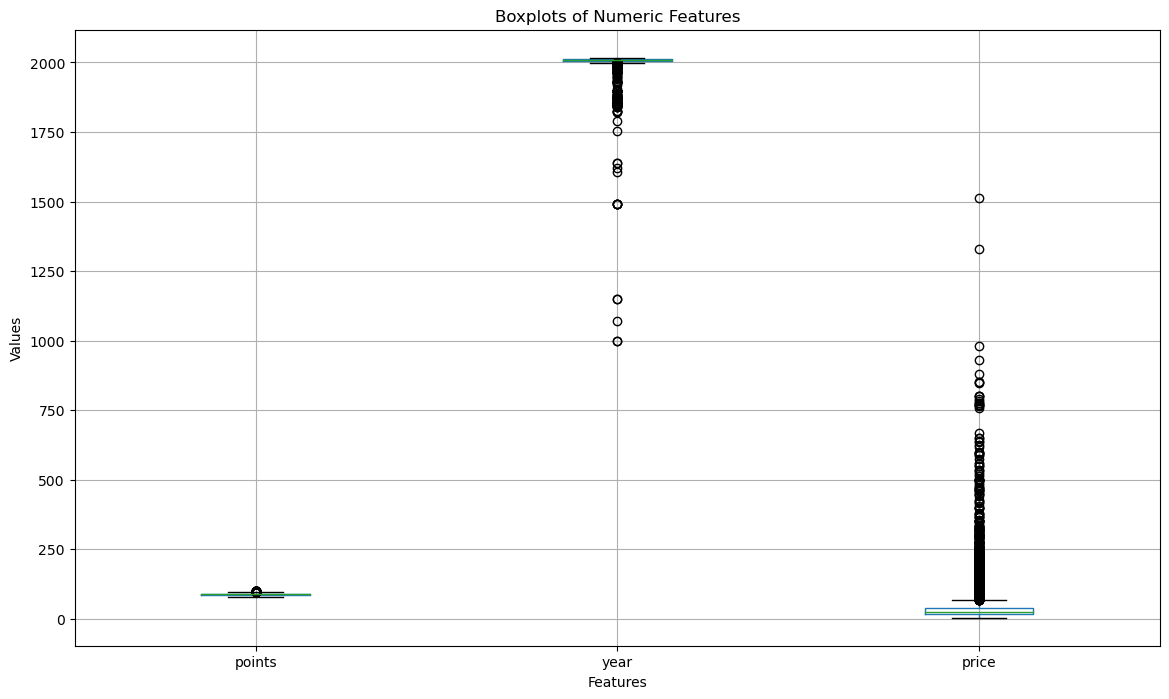

In [25]:
df3.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(14,8))

# add title
plt.title('Boxplots of Numeric Features')

# add x-axis label
plt.xlabel('Features')

# add y-axis label
plt.ylabel('Values')

plt.show()

### Outliers in 'price' column 

I have a lot of outliers in the price column, so I will drop them.

In [26]:
Q1 = df3['price'].quantile(0.25)
Q3 = df3['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df3[(df3['price'] > (Q3 + 1.5 * IQR))]
num_outliers = outliers['price'].count()
print("Number of outlier values in 'price' column: ", num_outliers)  

Number of outlier values in 'price' column:  2019


In [27]:
# Drop outliers from the original dataframe
df3 = df3.drop(outliers.index)

# Verify the number of rows in the dataframe after removing outliers
print("Number of rows after removing outliers: ", len(df3))

Number of rows after removing outliers:  24062


In [28]:
Q1 = df3['points'].quantile(0.25)
Q3 = df3['points'].quantile(0.75)
IQR = Q3 - Q1
# find outliers
outliers_points = df3[(df3['points'] < (Q1 - 1.5 * IQR)) | (df3['points'] > (Q3 + 1.5 * IQR))]
num_outliers = outliers_points['points'].count()
print("Number of outlier values in 'points' column: ", num_outliers)

Number of outlier values in 'points' column:  3


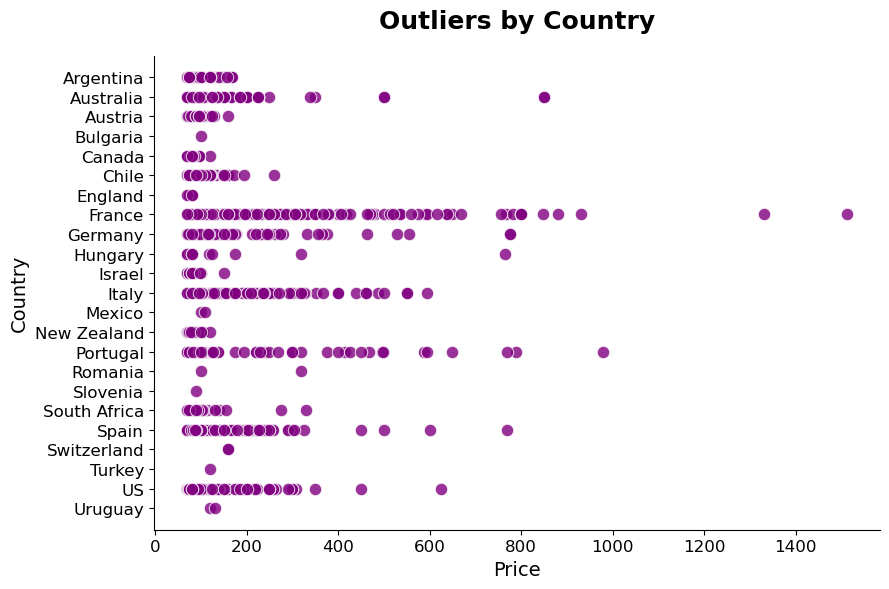

In [29]:
# Visualize outliers by country
fig, ax = plt.subplots(figsize=(9,6))
sns.scatterplot(x='price', y='country', data=outliers, ax=ax, color='purple', alpha=0.8, s=80)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Country', fontsize=14)
ax.set_title('Outliers by Country', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

### Boxplot of 'price' column after removing outliers

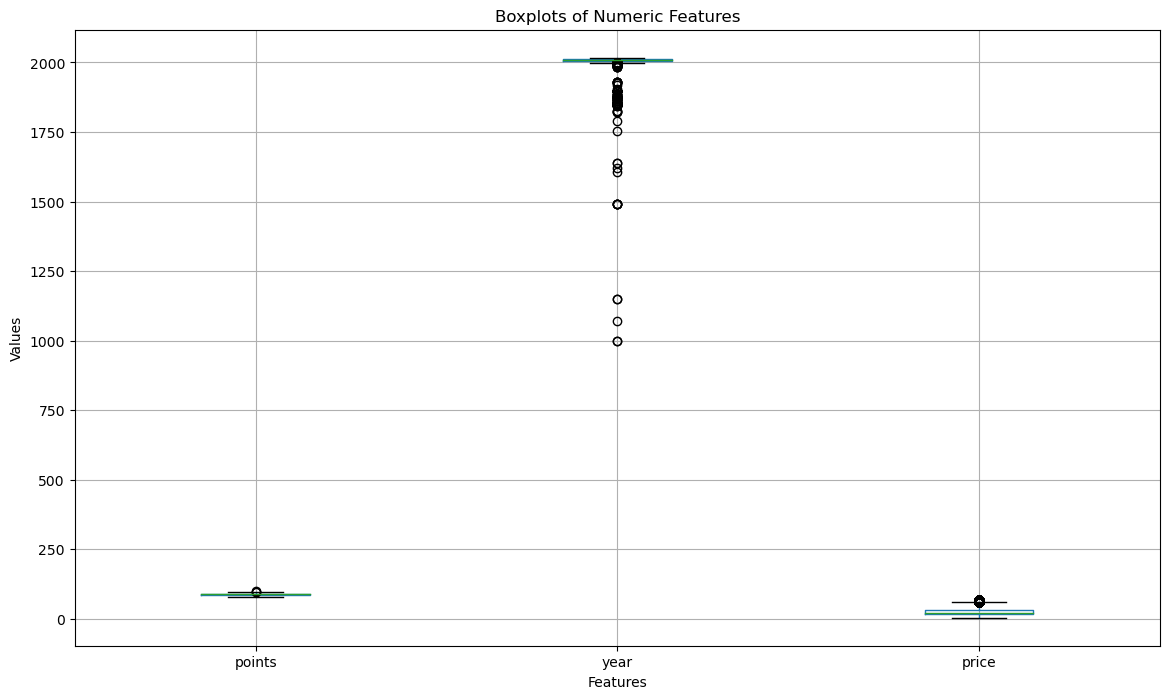

In [30]:
df3.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(14,8))

# add title
plt.title('Boxplots of Numeric Features')

# add x-axis label
plt.xlabel('Features')

# add y-axis label
plt.ylabel('Values')

plt.show()

### Scaling and TF-IDF

In [102]:
# extract the features and labels
X = df3.drop('points', axis=1)
y = df3['points']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reset the index of the training and testing sets
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [103]:
# create one-hot encoder object
one_hot_encoder = ce.OneHotEncoder()

# fit and transform variety column
variety_train_encoded = one_hot_encoder.fit_transform(X_train['variety'])
variety_test_encoded = one_hot_encoder.transform(X_test['variety'])

# add the encoded columns to the original dataframes
X_train = pd.concat([X_train.drop('variety', axis=1), variety_train_encoded], axis=1)
X_test = pd.concat([X_test.drop('variety', axis=1), variety_test_encoded], axis=1)

# fit and transform country column
country_train_encoded = one_hot_encoder.fit_transform(X_train['country'])
country_test_encoded = one_hot_encoder.transform(X_test['country'])

# add the encoded columns to the original dataframes
X_train = pd.concat([X_train.drop('country', axis=1), country_train_encoded], axis=1)
X_test = pd.concat([X_test.drop('country', axis=1), country_test_encoded], axis=1)

# fit and transform continent column
continent_train_encoded = one_hot_encoder.fit_transform(X_train['continent'])
continent_test_encoded = one_hot_encoder.transform(X_test['continent'])

# add the encoded columns to the original dataframes
X_train = pd.concat([X_train.drop('continent', axis=1), continent_train_encoded], axis=1)
X_test = pd.concat([X_test.drop('continent', axis=1), continent_test_encoded], axis=1)

# select only the numerical features for scaling
numerical_features = ['price', 'year']

# instantiate the StandardScaler and fit_transform on X_train
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])

# transform X_test using the fitted scaler from X_train
X_test_scaled = scaler.transform(X_test[numerical_features])

# scale y_train and y_test
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# apply tf-idf on the description column
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=0.001)
X_tfidf = tfidf.fit_transform(X_train['description'])
X_tfidf_test = tfidf.transform(X_test['description'])

# get the feature names from the tf-idf object
tfidf_features = tfidf.get_feature_names_out()

# combine the tf-idf output with the other features of X_train
X_train_processed = pd.concat([
    X_train.drop(['description', 'price', 'year'], axis=1).reset_index(drop=True), 
    pd.DataFrame(X_tfidf.toarray(), columns=tfidf_features),
    pd.DataFrame(X_train_scaled, columns=['price', 'year'])
], axis=1)

# combine the tf-idf output with the other features of X_test
X_test_processed = pd.concat([
    X_test.drop(['description', 'price', 'year'], axis=1).reset_index(drop=True), 
    pd.DataFrame(X_tfidf_test.toarray(), columns=tfidf_features),
    pd.DataFrame(X_test_scaled, columns=['price', 'year'])
], axis=1)

In [85]:
X_train_processed.isnull().sum()

variety_1    0
variety_2    0
variety_3    0
variety_4    0
variety_5    0
            ..
zippy        0
zweigelt     0
émilion      0
price        0
year         0
Length: 5468, dtype: int64

In [86]:
X_test_processed.isnull().sum()

variety_1    0
variety_2    0
variety_3    0
variety_4    0
variety_5    0
            ..
zippy        0
zweigelt     0
émilion      0
price        0
year         0
Length: 5468, dtype: int64

In [92]:
X_train_processed

,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10,...,zinfandels,zing,zingy,zins,zip,zippy,zweigelt,émilion,price,year
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261279,0.990167
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.271525,0.998033
2,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276648,0.990167
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522558,0.988201
4,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.438795,0.994100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245910,0.997050
19245,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169063,0.995084
19246,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192117,0.995084
19247,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092216,0.993117


In [93]:
X_test_processed

,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10,...,zinfandels,zing,zingy,zins,zip,zippy,zweigelt,émilion,price,year
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122955,0.996067
1,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184432,0.978368
2,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322757,0.989184
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230540,0.997050
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553297,0.994100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215171,0.991150
4809,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.783837,0.987217
4810,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153694,0.996067
4811,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553297,0.990167


### A function to evaluate the performance of different models

In [99]:
def evaluate_model(model, X, y, n_folds=5):
    # Define the K-Fold cross-validation object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Define lists to store the RMSE scores for each fold
    fold_rmse_scores = []

    # Loop over the folds
    for train_index, val_index in kf.split(X):
        # Split the data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the validation data
        y_val_pred = model.predict(X_val)

        # Calculate the RMSE score for the fold
        fold_rmse_score = np.sqrt(mean_squared_error(y_val, y_val_pred))

        # Add the RMSE score to the list of fold scores
        fold_rmse_scores.append(fold_rmse_score)

    # Calculate the mean RMSE score across all folds
    mean_rmse_score = np.mean(fold_rmse_scores)

    return mean_rmse_score, fold_rmse_scores

Ridge Regression was the best model for this dataset, so I removed other models' test results.

### SVM
RMSE - 0.0795

R2 - 0.7745

SVM took very long to run so you might want to skip to Ridge Regression

In [151]:
# do the same for svm
svr = SVR(C=10, epsilon=0.1, gamma='scale')

# uncomment following three lines to evaluate the model, but it takes a long time

# svr_rmse, svr_fold_scores = evaluate_model(svr, X_train_processed, y_train)
# print("SVR Mean RMSE Score:", round(svr_rmse, 4))
# print("SVR Fold RMSE Scores:", [round(i, 4) for i in svr_fold_scores])

In [152]:
# fit svm
svr.fit(X_train_processed, y_train)

# predict on test set
y_pred_svr = svr.predict(X_test_processed)

# calculate RMSE
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print("SVR RMSE:", round(svr_rmse, 4))

# calculate R2
svr_r2 = r2_score(y_test, y_pred_svr)
print("SVR R2:", round(svr_r2, 4))

c:\Users\Asmar\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR RMSE: 0.0868
SVR R2: 0.7374


In [153]:
# evaluate the model using .score() method
print("SVR Score:", round(svr.score(X_test_processed, y_test), 4))

SVR Score: 0.7374


#### Actual vs. Predicted Points with SVM

In [39]:
# create a DataFrame with the actual and predicted prices
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# create a regression plot with the actual and predicted prices
sns.regplot(x='Actual', y='Predicted', data=df, scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})

# set plot size
plt.rcParams['figure.figsize'] = (10, 5)

# add x-axis and y-axis labels
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

# add a title
plt.title('Actual vs. Predicted Points with SVM')

# show the plot
plt.show()

### RIDGE REGRESSION

RMSE: 0.0889

R-squared: 0.7242

In [144]:
ridge = Ridge(alpha=3, random_state=42)

# uncomment following three lines to evaluate the model

# ridge_rmse, ridge_fold_scores = evaluate_model(ridge, X_train_processed, y_train)
# print("Ridge Regression Mean RMSE Score:", round(ridge_rmse, 4))
# print("Ridge Regression Fold RMSE Scores:", [round(i, 4) for i in ridge_fold_scores])

In [145]:
# fit ridge
ridge.fit(X_train_processed, y_train)

# predict on the test set
y_pred_ridge = ridge.predict(X_test_processed)

# calculate the RMSE score
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("RMSE:", round(rmse, 4))

# calculate the R-squared score
r2 = r2_score(y_test, y_pred_ridge)
print("R-squared:", round(r2, 4))

RMSE: 0.0889
R-squared: 0.7242


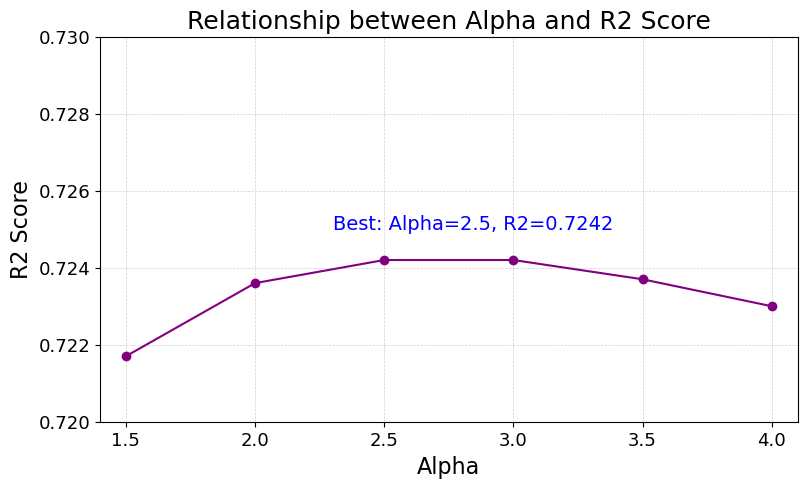

In [42]:
# relationship between alpha and r2 score
alpha = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
r2_scoree = [0.7217, 0.7236, 0.7242, 0.7242, 0.7237, 0.7230]

# set font size
plt.rcParams.update({'font.size': 13})

# create figure and axis objects
fig, ax = plt.subplots(figsize=(9, 5))

# create scatter plot with colors and alpha
ax.plot(alpha, r2_scoree, marker='o', color='purple')

# set axis labels and title
ax.set_xlabel('Alpha', fontsize=16)
ax.set_ylabel('R2 Score', fontsize=16)
ax.set_title('Relationship between Alpha and R2 Score', fontsize=18)

# set x and y axis limits
ax.set_xlim([1.4, 4.1])
ax.set_ylim([0.72, 0.73])

# add grid lines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# add text
ax.text(2.3, 0.725, 'Best: Alpha=2.5, R2=0.7242', fontsize=14, color='b')

plt.show()

In [43]:
# cross-validation score
ridge_cv_score = cross_val_score(ridge, X_train_processed, y_train, cv=5, scoring='neg_root_mean_squared_error')

# print the mean cross-validation score
print("Mean Cross-Validation Score:", round(-ridge_cv_score.mean(), 4))

Mean Cross-Validation Score: 0.089


#### Actual vs. Predicted Points with Ridge Regression

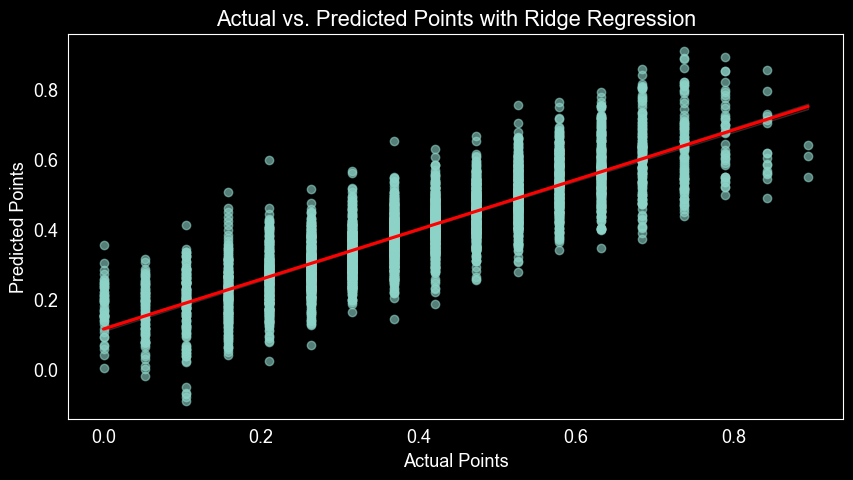

In [150]:
# create a DataFrame with the actual and predicted prices
df = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': y_pred_ridge.ravel()})

# create a regression plot with the actual and predicted prices
sns.regplot(x='Actual', y='Predicted', data=df, scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})

# set plot size
plt.rcParams['figure.figsize'] = (10, 5)

# add x-axis and y-axis labels
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

# set dark background
plt.style.use('dark_background')

# add a title
plt.title('Actual vs. Predicted Points with Ridge Regression')

# show the plot
plt.show()

## Neural Network

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_processed = torch.tensor(np.array(X_train_processed)).float()
X_test_processed = torch.tensor(np.array(X_test_processed)).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

# Create a PyTorch DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_processed, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_processed, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_processed.shape[1], 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        return x

# Create an instance of the neural network
model = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, loss: {running_loss/len(train_loader):.6f}, r2 score: {r2_score(labels.detach().numpy(), outputs.detach().numpy()):.6f}, rmse: {np.sqrt(mean_squared_error(labels.detach().numpy(), outputs.detach().numpy())):.6f}")

# Evaluate the model on the test set
with torch.no_grad():
    y_pred = model(X_test_processed)
    test_loss = criterion(y_pred, y_test)
print('Test loss:', test_loss.item())

C:\Users\Asmar\AppData\Local\Temp\ipykernel_9544\2114977266.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\Asmar\AppData\Local\Temp\ipykernel_9544\2114977266.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()


Epoch 1, loss: 0.019768, r2 score: 0.418835, rmse: 0.145951
Epoch 2, loss: 0.007270, r2 score: 0.680086, rmse: 0.093155
Epoch 3, loss: 0.006426, r2 score: 0.664311, rmse: 0.102543
Epoch 4, loss: 0.006082, r2 score: 0.789330, rmse: 0.085261
Epoch 5, loss: 0.005882, r2 score: 0.868228, rmse: 0.054039
Test loss: 0.00840323232114315


In [143]:
# Compute evaluation metrics
mse = ((y_pred.numpy() - y_test.numpy()) ** 2).mean()
rmse = np.sqrt(mse)
mae = np.abs(y_pred.numpy() - y_test.numpy()).mean()
r2 = r2_score(y_test.numpy(), y_pred.numpy())

# Print evaluation metrics
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2: {r2:.6f}")

MSE: 0.008403
RMSE: 0.091669
MAE: 0.071222
R2: 0.706834
